In [ ]:
from __future__ import print_function
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Activation,Dropout
from tensorflow import keras
from sklearn.metrics import mean_squared_error, r2_score
import os
from tensorflow.python.keras.callbacks import EarlyStopping
import warnings
from keras.models import load_model
import seaborn as sns

In [ ]:
start_time = time.time()

# Reading from the database
dataset = pd.read_csv('hourly_load&weather_data.csv')
train_dates=pd.to_datetime(dataset['Date'])
cols=list(dataset)[1:7]
# colsload=list(dataset)[1:2]
# colsload

<ipython-input-127-0bffaed439de>:5: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  train_dates=pd.to_datetime(dataset['Date'])


In [ ]:
df_for_training = dataset[cols].astype(float)
# df_for_training_load = dataset[colsload].astype(float)
df_for_training

Load  Temperature  Dew Point  Humidity  Wind Speed  Pressure
0    45972.0         25.1       16.2      58.5         8.3    1010.8
1    41718.0         26.1       17.3      60.2         9.3    1012.7
2    50254.0         24.9       19.7      73.2         8.7    1012.5
3    50351.0         25.1       15.0      54.5         9.5    1011.9
4    49277.0         25.4       12.6      46.1         9.8    1011.6
..       ...          ...        ...       ...         ...       ...
359  40249.0         24.0       15.4      60.0         7.0    1010.8
360  45006.0         23.8       15.4      60.6         6.9    1011.5
361  45643.0         24.5       15.7      59.2         6.4    1011.9
362  46569.0         26.3       12.5      44.4         6.5    1011.2
363  45230.0         27.1       12.7      41.6         9.9    1011.8

[364 rows x 6 columns]

In [ ]:
# Normalising the data using the MinMaxScaler
scaler =StandardScaler()
scaler=scaler.fit(df_for_training)
df_for_training_scaled=scaler.transform(df_for_training)
# scaler11=scaler.fit(df_for_training_load)

# df_for_training_scaled_load=scalerl.transform(df_for_training_load)
df_for_training_scaled.shape

(364, 6)

In [ ]:
trainX = []
trainY =[]
n_future = 1
n_past = 1

for i in range(n_past, len(df_for_training_scaled)+1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])

trainX = np.array(trainX)


In [ ]:
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape[1]))

trainX shape == (364, 1, 5).
trainY shape == 1.


In [ ]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_47 (LSTM)              (None, 1, 64)             17920     
                                                                 
 lstm_48 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_11 (Dropout)        (None, 32)                0         
                                                                 
 dense_16 (Dense)            (None, 1)                 33        
                                                                 
Total params: 30369 (118.63 KB)
Trainable params: 30369 (118.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/5
21/21 [==============================] - 5s 92ms/step - loss: 2427096832.0000 - val_loss: 2161808640.0000
Epoch 2/5
21/21 [==============================] - 1s 28ms/step - loss: 2427084544.0000 - val_loss: 2161795328.0000
Epoch 3/5
21/21 [==============================] - 0s 24ms/step - loss: 2427054592.0000 - val_loss: 2161761792.0000
Epoch 4/5
21/21 [==============================] - 0s 18ms/step - loss: 2426976000.0000 - val_loss: 2161662976.0000
Epoch 5/5
21/21 [==============================] - 0s 19ms/step - loss: 2426722304.0000 - val_loss: 2161367552.0000


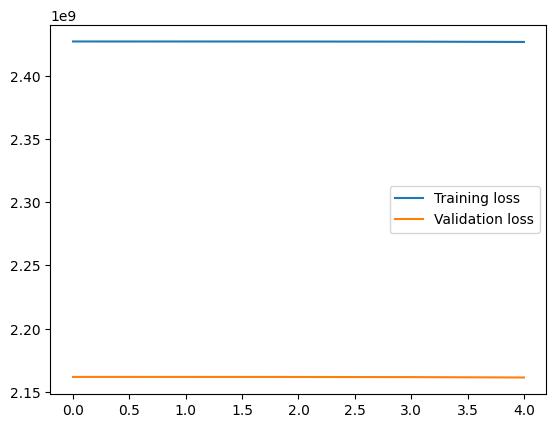

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [ ]:
n_past = 16
n_days_for_prediction=15  #let us predict past 15 days

predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction).tolist()
trainX.shape

(364, 1, 5)

In [ ]:
prediction = model.predict(trainX)
print(prediction[:4])


12/12 [==============================] - 0s 2ms/step
[[5.2211957]
 [4.928705 ]
 [3.6121848]
 [6.465963 ]]


In [ ]:
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

In [ ]:
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]
y_pred_future

array([ 71528.36 ,  70254.97 ,  64523.363,  76947.58 ,  85510.14 ,
        93054.01 ,  89950.6  ,  74755.16 ,  73832.016,  65267.48 ,
        70375.71 ,  73748.12 ,  81682.63 ,  81216.59 ,  85888.055,
        75531.05 ,  74522.6  ,  78773.47 ,  69049.11 ,  66877.7  ,
        75135.   ,  84589.72 ,  85472.78 ,  70376.234, 109089.375,
        97611.49 ,  94125.805,  74638.336,  64395.95 ,  64814.293,
        58753.312,  59992.52 ,  58932.49 ,  57332.992,  58539.22 ,
        65357.01 ,  67518.49 ,  58851.727,  59365.906,  65894.71 ,
        72025.57 ,  81206.49 ,  80473.695,  85822.55 ,  89997.516,
        83397.266,  71285.8  ,  66685.54 ,  57959.074,  56691.5  ,
        55189.31 ,  57523.406,  57560.04 ,  56933.44 ,  57243.496,
        56371.71 ,  62997.184,  64583.363,  59271.984,  57834.05 ,
        55951.746,  57798.246,  58056.527,  57452.656,  56583.664,
        56001.168,  54843.92 ,  55296.35 ,  55274.508,  59014.46 ,
        59424.72 ,  60806.14 ,  63506.2  ,  63906.61 ,  61988.

In [ ]:
new_df=pd.DataFrame({'predicted_Load':y_pred_future})
new_df.head()

predicted_Load
0    71528.359375
1    70254.968750
2    64523.363281
3    76947.578125
4    85510.140625

In [ ]:
new_df = pd.concat([new_df,df_for_training_load],axis=1)
new_df

predicted_Load     Load
0      71528.359375  45972.0
1      70254.968750  41718.0
2      64523.363281  50254.0
3      76947.578125  50351.0
4      85510.140625  49277.0
..              ...      ...
359    76936.273438  40249.0
360    79330.757812  45006.0
361    79648.726562  45643.0
362    91402.718750  46569.0
363    86043.851562  45230.0

[364 rows x 2 columns]

start


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, concatenate
from tensorflow.keras.models import Model

# Generate some sample data
dataset = pd.read_csv('hourly_load&weather_data.csv')
train_dates=pd.to_datetime(dataset['Date'])

np.random.seed(42)
x1= dataset[['Temperature','Dew Point','Humidity']]

x2 = dataset[['Wind Speed','Pressure']]
y=dataset['Load']

scaler =StandardScaler()
scaler=scaler.fit(x1)
X1=scaler.transform(x1)
scaler1=scaler.fit(x2)
X2=scaler1.transform(x2)
# scaler2=scaler.fit(Y.array.reshape(-1, 1))
# y=scaler2.transform(Y.array.reshape(-1, 1))
# Split the data into training and testing sets
X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(X1, X2, y, test_size=0.2, random_state=42)

# Define the first input layer
input_1 = Input(shape=(3,))

# Define the second input layer
input_2 = Input(shape=(2,))

# Concatenate the two input layers
merged_inputs = concatenate([input_1, input_2])

# Add a hidden layer
hidden_layer = Dense(64, activation='relu')(merged_inputs)

# Output layer
output_layer = Dense(1, activation='sigmoid')(hidden_layer)

# Create the model
model = Model(inputs=[input_1, input_2], outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
model.fit([X1_train, X2_train], y_train, epochs=30, batch_size=16, validation_split=0.2)

# Evaluate the model on the test set
eval_result = model.evaluate([X1_test, X2_test], y_test)
print("\nTest Loss:", eval_result[0])
print("Test Accuracy:", eval_result[1])

# Make predictions on new data
new_data_X1 = np.array([[28.6	,17,	49.6	]])
new_data_X2 = np.array([[12.7,	1011.1]])
predictions = model.predict([new_data_X1, new_data_X2])
# p=scaler.inverse_transform(predictions)
print("\nPredictions on new data:")
print(predictions)

Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_49 (InputLayer)       [(None, 3)]                  0         []                            
                                                                                                  
 input_50 (InputLayer)       [(None, 2)]                  0         []                            
                                                                                                  
 concatenate_24 (Concatenat  (None, 5)                    0         ['input_49[0][0]',            
 e)                                                                  'input_50[0][0]']            
                                                                                                  
 dense_48 (Dense)            (None, 64)                   384       ['concatenate_24[0][0]'

<ipython-input-48-8af7c028a1ae>:10: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  train_dates=pd.to_datetime(dataset['Date'])


15/15 [==============================] - 1s 16ms/step - loss: -779.5912 - accuracy: 0.0000e+00 - val_loss: -8407.6523 - val_accuracy: 0.0000e+00
Epoch 2/30
15/15 [==============================] - 0s 5ms/step - loss: -18547.4668 - accuracy: 0.0000e+00 - val_loss: -24811.8594 - val_accuracy: 0.0000e+00
Epoch 3/30
15/15 [==============================] - 0s 5ms/step - loss: -36314.5742 - accuracy: 0.0000e+00 - val_loss: -41838.5117 - val_accuracy: 0.0000e+00
Epoch 4/30
15/15 [==============================] - 0s 5ms/step - loss: -55022.1914 - accuracy: 0.0000e+00 - val_loss: -59741.0078 - val_accuracy: 0.0000e+00
Epoch 5/30
15/15 [==============================] - 0s 4ms/step - loss: -74904.0156 - accuracy: 0.0000e+00 - val_loss: -79422.5000 - val_accuracy: 0.0000e+00
Epoch 6/30
15/15 [==============================] - 0s 5ms/step - loss: -96825.2500 - accuracy: 0.0000e+00 - val_loss: -100959.5391 - val_accuracy: 0.0000e+00
Epoch 7/30
15/15 [==============================] - 0s 5ms/step 

In [ ]:
[[48797.355]]


lstm


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, LSTM, Dense, concatenate
from tensorflow.keras.models import Model

# Load dataset
dataset = pd.read_csv('hourly_load&weather_data.csv')
x1 = dataset[['Temperature', 'Dew Point', 'Humidity']]
x2 = dataset[['Wind Speed', 'Pressure']]
y = dataset['Load']

# Standardize features
scaler_x1 = StandardScaler()
X1 = scaler_x1.fit_transform(x1)

scaler_x2 = StandardScaler()
X2 = scaler_x2.fit_transform(x2)

# Reshape data for LSTM (timesteps, features)
X1 = X1.reshape((X1.shape[0], 1, X1.shape[1]))
X2 = X2.reshape((X2.shape[0], 1, X2.shape[1]))

# Split the data into training and testing sets
X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(X1, X2, y, test_size=0.1, random_state=32)

# Define the first input layer for LSTM
input_1 = Input(shape=(X1.shape[1], X1.shape[2]))

# Define the second input layer for LSTM
input_2 = Input(shape=(X2.shape[1], X2.shape[2]))

# Concatenate the two input layers
merged_inputs = concatenate([input_1, input_2])

# LSTM layer
lstm_layer = LSTM(64, activation='relu')(merged_inputs)

# Output layer
output_layer = Dense(1, activation='linear')(lstm_layer)

# Create the model
model = Model(inputs=[input_1, input_2], outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')  # For regression, use mean squared error

# Print the model summary
model.summary()

# Train the model
model.fit([X1_train, X2_train], y_train, epochs=33, batch_size=10, validation_split=0.2)

# Evaluate the model on the test set
eval_result = model.evaluate([X1_test, X2_test], y_test)
print("\nTest Loss:", eval_result)

# Make predictions on new data
new_data_X1 = np.array([[27.1,	14.1,	45	],
                        [28.8,	17.2	,50.9],
                        [27	,17.9	,58.7],
                        [25.6,	16.4	,57.6],
                        [25.7	,16.1	,56.7],
                        [26.2	,17.5	,60.2],
                        [26.8,	16.7	,55.2],
                        [26.8,	16.7,	55.2],
                        [27.6,	16.2	,50.2],
                        [27	,13.5,	44.1],
                        [25.5,	14.7,	53.5],
                        [26.1	,16.9,	57.6],
                        [26.8	,17.1,	56.6],])
new_data_X2 = np.array([[14.5,	1012.2	],
                        [8.5	,1009.7],
                        [10.4	,1008.8],
                        [	9	,1008.7],
                        [9	,1008.7],
                        [6.4	,1007.6],
                        [7.8	,1008.6],
                        [8.3	,1009.7],
                        [7	,1010.2],
                        [7.1,	1011.1],
                        [9.3	,1010.8],
                        [7.5	,1009.7],
                        [7.4,	1010.2],])
new_data_X1 = new_data_X1.reshape((new_data_X1.shape[0], 1, new_data_X1.shape[1]))
new_data_X2 = new_data_X2.reshape((new_data_X2.shape[0], 1, new_data_X2.shape[1]))

predictions = model.predict([new_data_X1, new_data_X2])
print("\nPredictions on new data:")
print(predictions)


Model: "model_98"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_197 (InputLayer)      [(None, 1, 3)]               0         []                            
                                                                                                  
 input_198 (InputLayer)      [(None, 1, 2)]               0         []                            
                                                                                                  
 concatenate_98 (Concatenat  (None, 1, 5)                 0         ['input_197[0][0]',           
 e)                                                                  'input_198[0][0]']           
                                                                                                  
 lstm_61 (LSTM)              (None, 64)                   17920     ['concatenate_98[0][0]'

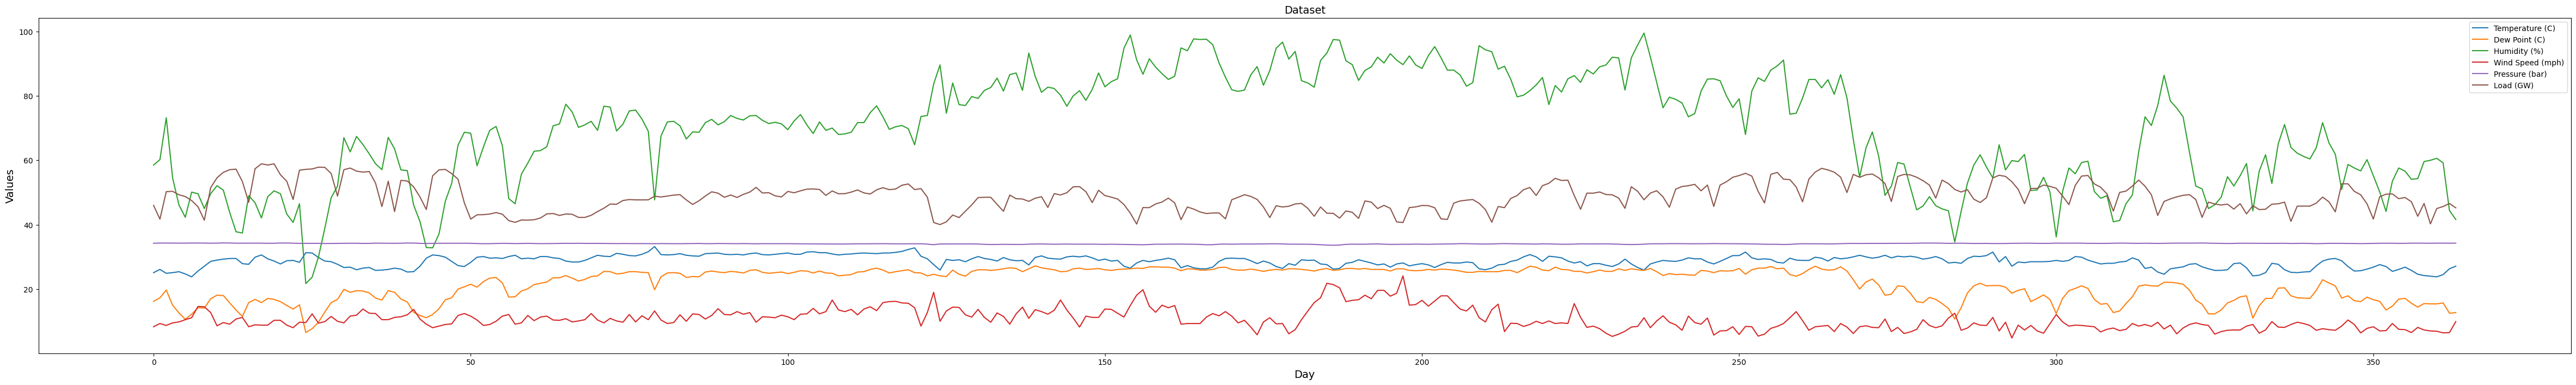


Independent & Dependent variables arrays:
x_temperature: (364, 1)
x_dewpoint: (364, 1)
x_humidity: (364, 1)
x_windspeed: (364, 1)
x_pressure: (364, 1)
y: (364, 1)

Stacked Dataset (364, 6) :
 [[0.13829787 0.46859903 0.47300771 0.18134715 0.86511628 0.31501404]
 [0.24468085 0.52173913 0.49485861 0.23316062 0.95348837 0.08956489]
 [0.11702128 0.63768116 0.66195373 0.20207254 0.94418605 0.54194711]
 ...
 [0.07446809 0.44444444 0.48200514 0.08290155 0.91627907 0.29757804]
 [0.26595745 0.28985507 0.29177378 0.0880829  0.88372093 0.34665324]
 [0.35106383 0.29951691 0.25578406 0.2642487  0.91162791 0.27569029]]

X.shape  (321, 30, 5)
y.shape (321, 15)

train_X (318, 30, 5)
train_y (318, 15)
test_X (3, 30, 5)
test_y (3, 15)
Epoch 1/100
11/11 [==============================] - 9s 153ms/step - loss: 0.2455 - mse: 0.2455 - val_loss: 0.1387 - val_mse: 0.1387
Epoch 2/100
11/11 [==============================] - 1s 78ms/step - loss: 0.2446 - mse: 0.2446 - val_loss: 0.1380 - val_mse: 0.1380
Epoch 3/

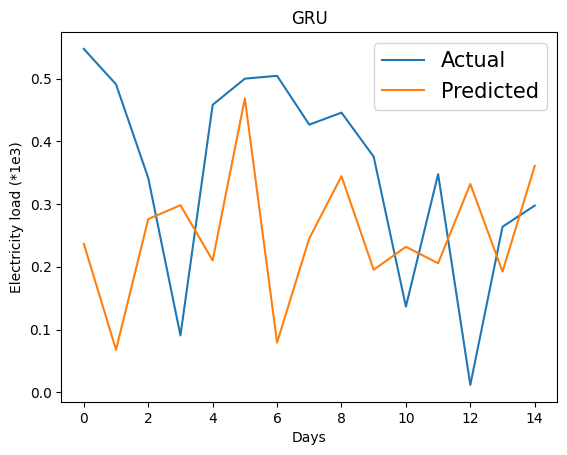

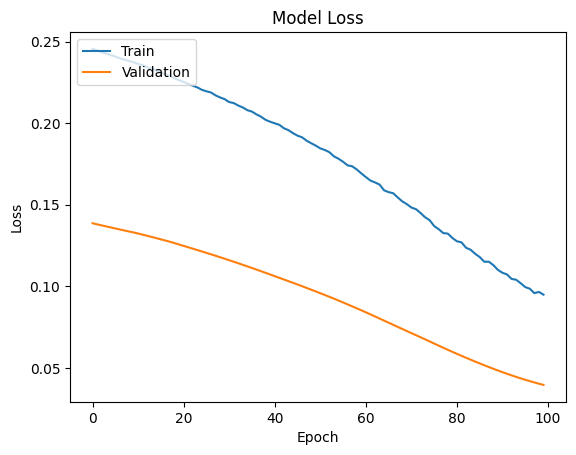

RMSE: 211.84520975741458
R-squared: -1.1129917644087395
MAPE: 2.36178959552782 

Total time:  93.33943557739258


In [ ]:
from __future__ import print_function
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Activation
from tensorflow import keras
from sklearn.metrics import mean_squared_error, r2_score
import os
from tensorflow.python.keras.callbacks import EarlyStopping
import warnings
from keras.models import load_model

warnings.filterwarnings("ignore", category=DeprecationWarning)

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

start_time = time.time()

# Reading from the database
dataset = pd.read_csv('hourly_load&weather_data.csv')
x_temperature = dataset['Temperature']
x_dewpoint = dataset['Dew Point']
x_humidity = dataset['Humidity']
x_windspeed = dataset['Wind Speed']
x_pressure = dataset['Pressure']
y = dataset['Load']

# Converting the values in the usable format
x_temperature = x_temperature.values
x_dewpoint = x_dewpoint.values
x_humidity = x_humidity.values
x_windspeed = x_windspeed.values
x_pressure = (x_pressure.values) / 29.53  # Hg to bar
y = (y.values)/1000 # MW to GW


# Visualising the independent variables
dataset_graph = plt.figure(figsize=(60, 8))
plt.plot(x_temperature[:364], label='Temperature (C)')
plt.plot(x_dewpoint[:364], label='Dew Point (C)')
plt.plot(x_humidity[:364], label='Humidity (%)')
plt.plot(x_windspeed[:364], label='Wind Speed (mph)')
plt.plot(x_pressure[:364], label='Pressure (bar)')
plt.plot(y[:364], label='Load (GW)')
plt.legend(loc='upper right')
plt.title("Dataset", fontsize=14)
plt.xlabel('Day', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.legend()
plt.show()



# Converting to a usable format in a 2D array
x_temperature = x_temperature.reshape((len(x_temperature), 1))
x_dewpoint = x_dewpoint.reshape((len(x_dewpoint), 1))
x_humidity = x_humidity.reshape((len(x_humidity), 1))
x_windspeed = x_windspeed.reshape((len(x_windspeed), 1))
x_pressure = x_pressure.reshape((len(x_pressure), 1))
y = y.reshape((len(y), 1))

print("\nIndependent & Dependent variables arrays:")
print("x_temperature:", x_temperature.shape)
print("x_dewpoint:", x_dewpoint.shape)
print("x_humidity:", x_humidity.shape)
print("x_windspeed:", x_windspeed.shape)
print("x_pressure:", x_pressure.shape)
print("y:", y.shape)

# Normalising the data using the MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
x_temperature_scaled = scaler.fit_transform(x_temperature)
x_dewpoint_scaled = scaler.fit_transform(x_dewpoint)
x_humidity_scaled = scaler.fit_transform(x_humidity)
x_windspeed_scaled = scaler.fit_transform(x_windspeed)
x_pressure_scaled = scaler.fit_transform(x_pressure)
y_scaled = scaler.fit_transform(y)


# Stacking the data columns horizontally
stacked_dataset = np.hstack(
    (x_temperature_scaled, x_dewpoint_scaled, x_humidity_scaled, x_windspeed_scaled, x_pressure_scaled, y_scaled))
print("\nStacked Dataset", stacked_dataset.shape, ":\n", stacked_dataset)


#Split a multivariate sequence into samples
def split_sequences(dataset, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(dataset)):
        start = i + n_steps_in
        end = start + n_steps_out-1
        if end > len(dataset):
            break
        x_sequence, y_sequence = dataset[i:start, :-1], dataset[start-1:end, -1]
        X.append(x_sequence)
        y.append(y_sequence)
    return np.array(X), np.array(y)

n_steps_in, n_steps_out, n_features = 30 , 15, 5
X, y = split_sequences(stacked_dataset, n_steps_in, n_steps_out)
print ("\nX.shape " , X.shape)
print ("y.shape" , y.shape)

#Splitting into training & test sets
train_X, train_y = X[:318, :], y[:318, :]
test_X, test_y = X[318:, :], y[318:, :]
print ("\ntrain_X" , train_X.shape)
print ("train_y" , train_y.shape)
print ("test_X" , test_X.shape)
print ("test_y" , test_y.shape)


#Learning Rate
opt = keras.optimizers.Adam(learning_rate=0.00001)

#GRU Model
model = Sequential()
model.add(GRU(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(GRU(50, activation='relu',return_sequences=True))
model.add(GRU(50, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(n_steps_out))
model.add(Activation('tanh'))
model.compile(loss='mse' , optimizer=opt , metrics=['mse'])
es = EarlyStopping(monitor="val_loss", min_delta=0, patience=5, verbose=1, mode="auto", baseline=None,
                   restore_best_weights=True)  # Stops the training when the values don't improve
history = model.fit(train_X, train_y, epochs=100, batch_size=30, verbose=1, validation_data=(test_X, test_y), callbacks=[es], shuffle=False)
print(model.summary())

# Evaluating the result
test_mse = model.evaluate(test_X, test_y, verbose=1)
# print('\nThe Mean-squared-error (MSE) on the test data set is %.6f over %d test samples.' % (test_mse, len(test_y)))
print("Test MSE:", test_mse)


# loaded_model = load_model('path')

# print("X", test_X.shape, test_X[65])
# Getting the predicted values
predicted_values = model.predict(test_X[0].reshape((1,30,5)))
scaler1 = MinMaxScaler(feature_range=(0, 1))
scaler1.fit(y)
y_pred = scaler1.inverse_transform(predicted_values)
test_scaled = scaler1.inverse_transform([test_y[0]])
y_pred = y_pred.reshape((15,))
test_scaled = test_scaled.reshape((15,))
print("P", y_pred)
print("y", test_scaled)
print("p", predicted_values, predicted_values.reshape((15,)))
print("y", test_y[0], test_y[0].shape)
# Plotting the results
fig = plt.figure()
plt.plot((test_y[0]))
plt.plot(predicted_values.reshape((15,)))
plt.title("GRU")
plt.xlabel('Days')
plt.ylabel('Electricity load (*1e3)')
plt.legend(('Actual', 'Predicted'), fontsize='15')
plt.show()


# Plot of the loss
loss_fig = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


end_time = time.time()

# print("MSE:", mean_squared_error(test_y[65].reshape((1,15))*1000, predicted_values*1000))
# print("RMSE:", mean_squared_error(test_y[65].reshape((1,15))*1000, predicted_values*1000, squared=False))
# print("MSE:", mean_squared_error(test_y[0]*1000, predicted_values.reshape((15,))*1000))
# print("RMSE:", mean_squared_error(test_y[0]*1000, predicted_values.reshape((15,))*1000, squared=False))
print("RMSE:", mean_squared_error(test_scaled*1000, y_pred*1000, squared=False))
# print("R-squared:", r2_score(test_y[65].reshape((1,15))*1000, predicted_values*1000))
print("R-squared:", r2_score(test_scaled, y_pred))
print('MAPE:', np.mean(np.abs((test_scaled*1000 - y_pred*1000) / (test_scaled*1000))),'\n')
print("Total time: ", end_time - start_time)

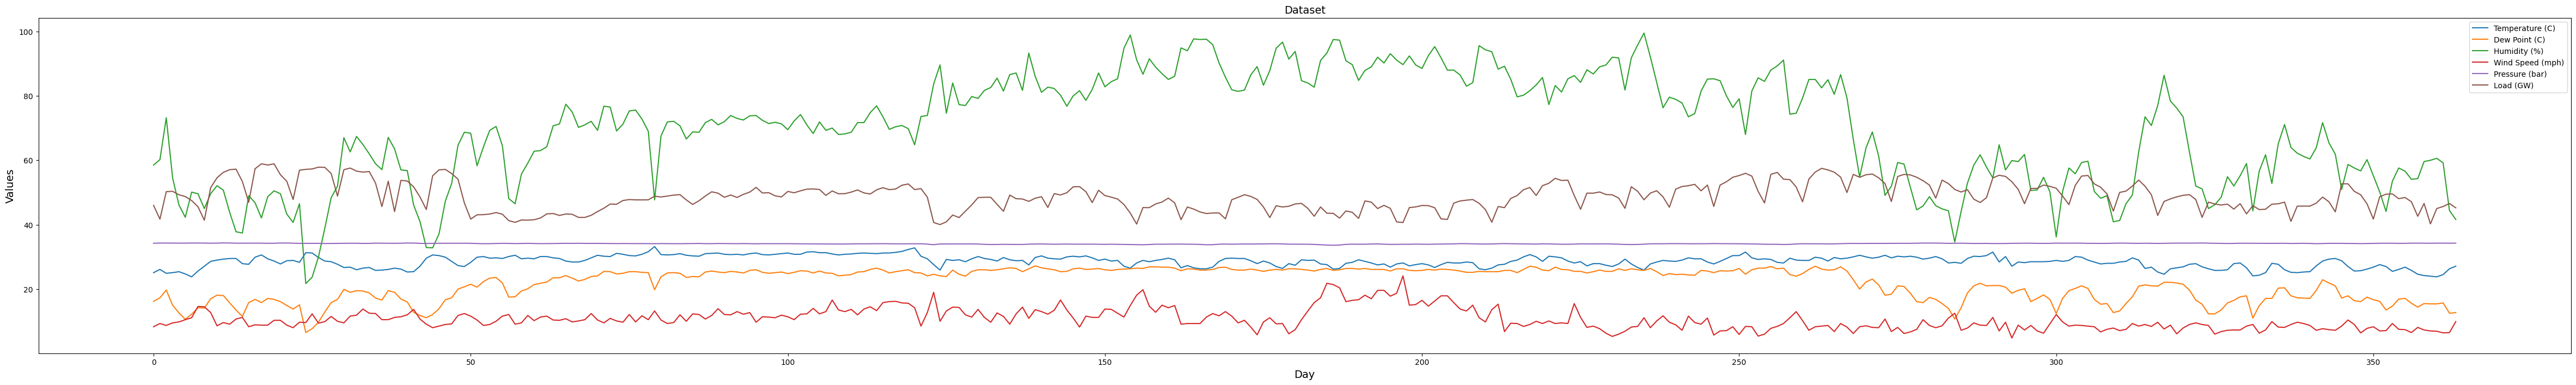


Independent & Dependent variables arrays:
x_temperature: (364, 1)
x_dewpoint: (364, 1)
x_humidity: (364, 1)
x_windspeed: (364, 1)
x_pressure: (364, 1)
y: (364, 1)

Stacked Dataset (364, 6) :
 [[0.13829787 0.46859903 0.47300771 0.18134715 0.86511628 0.31501404]
 [0.24468085 0.52173913 0.49485861 0.23316062 0.95348837 0.08956489]
 [0.11702128 0.63768116 0.66195373 0.20207254 0.94418605 0.54194711]
 ...
 [0.07446809 0.44444444 0.48200514 0.08290155 0.91627907 0.29757804]
 [0.26595745 0.28985507 0.29177378 0.0880829  0.88372093 0.34665324]
 [0.35106383 0.29951691 0.25578406 0.2642487  0.91162791 0.27569029]]

X.shape  (321, 30, 5)
y.shape (321, 15)

train_X (318, 30, 5)
train_y (318, 15)
test_X (3, 30, 5)
test_y (3, 15)
Epoch 1/100
11/11 [==============================] - 3s 72ms/step - loss: 0.2509 - mse: 0.2509 - val_loss: 0.1390 - val_mse: 0.1390
Epoch 2/100
11/11 [==============================] - 0s 33ms/step - loss: 0.2439 - mse: 0.2439 - val_loss: 0.1354 - val_mse: 0.1354
Epoch 3/1

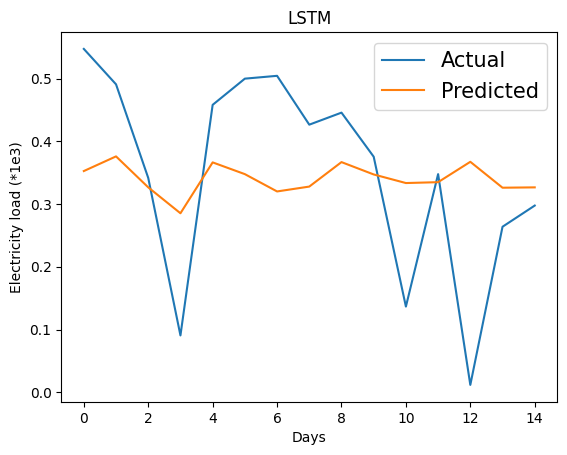

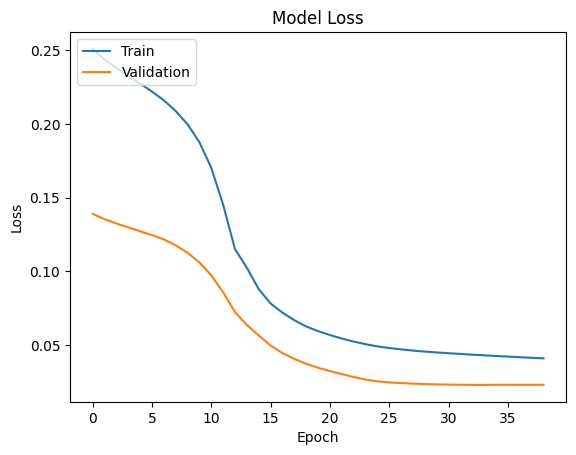

RMSE: 139.80850081907568
R-squared: 0.07970368511789572
MAPE: 2.420817440857701 

Total time:  24.20774745941162


In [ ]:
from __future__ import print_function
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Activation
from tensorflow import keras
from sklearn.metrics import mean_squared_error, r2_score
import os
from tensorflow.python.keras.callbacks import EarlyStopping
import warnings
from keras.models import load_model

warnings.filterwarnings("ignore", category=DeprecationWarning)

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

start_time = time.time()

# Reading from the database
dataset = pd.read_csv('hourly_load&weather_data.csv')
x_temperature = dataset['Temperature']
x_dewpoint = dataset['Dew Point']
x_humidity = dataset['Humidity']
x_windspeed = dataset['Wind Speed']
x_pressure = dataset['Pressure']
y = dataset['Load']

# Converting the values in the usable format
x_temperature = x_temperature.values
x_dewpoint = x_dewpoint.values
x_humidity = x_humidity.values
x_windspeed = x_windspeed.values
x_pressure = (x_pressure.values) / 29.53  # Hg to bar
y = (y.values) / 1000  # MW to GW


# Visualising the independent variables
dataset_graph = plt.figure(figsize=(60, 8))
plt.plot(x_temperature[:364], label='Temperature (C)')
plt.plot(x_dewpoint[:364], label='Dew Point (C)')
plt.plot(x_humidity[:364], label='Humidity (%)')
plt.plot(x_windspeed[:364], label='Wind Speed (mph)')
plt.plot(x_pressure[:364], label='Pressure (bar)')
plt.plot(y[:364], label='Load (GW)')
plt.legend(loc='upper right')
plt.title("Dataset", fontsize=14)
plt.xlabel('Day', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.legend()
plt.show()


# Converting to a usable format in a 2D array
x_temperature = x_temperature.reshape((len(x_temperature), 1))
x_dewpoint = x_dewpoint.reshape((len(x_dewpoint), 1))
x_humidity = x_humidity.reshape((len(x_humidity), 1))
x_windspeed = x_windspeed.reshape((len(x_windspeed), 1))
x_pressure = x_pressure.reshape((len(x_pressure), 1))
y = y.reshape((len(y), 1))

print("\nIndependent & Dependent variables arrays:")
print("x_temperature:", x_temperature.shape)
print("x_dewpoint:", x_dewpoint.shape)
print("x_humidity:", x_humidity.shape)
print("x_windspeed:", x_windspeed.shape)
print("x_pressure:", x_pressure.shape)
print("y:", y.shape)

# Normalising the data using the MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
x_temperature_scaled = scaler.fit_transform(x_temperature)
x_dewpoint_scaled = scaler.fit_transform(x_dewpoint)
x_humidity_scaled = scaler.fit_transform(x_humidity)
x_windspeed_scaled = scaler.fit_transform(x_windspeed)
x_pressure_scaled = scaler.fit_transform(x_pressure)
y_scaled = scaler.fit_transform(y)


# Stacking the data columns horizontally
stacked_dataset = np.hstack(
    (x_temperature_scaled, x_dewpoint_scaled, x_humidity_scaled, x_windspeed_scaled, x_pressure_scaled, y_scaled))
print("\nStacked Dataset", stacked_dataset.shape, ":\n", stacked_dataset)


#Split a multivariate sequence into samples
def split_sequences(dataset, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(dataset)):
        start = i + n_steps_in
        end = start + n_steps_out-1
        if end > len(dataset):
            break
        x_sequence, y_sequence = dataset[i:start, :-1], dataset[start-1:end, -1]
        X.append(x_sequence)
        y.append(y_sequence)
    return np.array(X), np.array(y)

n_steps_in, n_steps_out, n_features = 30 , 15, 5
X, y = split_sequences(stacked_dataset, n_steps_in, n_steps_out)
print ("\nX.shape " , X.shape)
print ("y.shape" , y.shape)

#Splitting into training & test sets
train_X, train_y = X[:318, :], y[:318, :]
test_X, test_y = X[318:, :], y[318:, :]
print ("\ntrain_X" , train_X.shape)
print ("train_y" , train_y.shape)
print ("test_X" , test_X.shape)
print ("test_y" , test_y.shape)


#Learning Rate
opt = keras.optimizers.Adam(learning_rate=0.0001)

#LSTM Model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(n_steps_out))
model.add(Activation('linear'))
model.compile(loss='mse' , optimizer=opt , metrics=['mse'])
es = EarlyStopping(monitor="val_loss", min_delta=0, patience=5, verbose=1, mode="auto", baseline=None,
                   restore_best_weights=True)  # Stops the training when the values don't improve
history = model.fit(train_X, train_y, epochs=100, batch_size=30, verbose=1, validation_data=(test_X, test_y), callbacks=[es], shuffle=False)
print(model.summary())

# Evaluating the result
test_mse = model.evaluate(test_X, test_y, verbose=1)
# print('\nThe Mean-squared-error (MSE) on the test data set is %.6f over %d test samples.' % (test_mse, len(test_y)))
print("Test MSE:", test_mse)

model.save('assets/multivariate/lstm.tf', overwrite=True, include_optimizer=True)
# loaded_model = load_model('path')


# print("X", test_X.shape, test_X[65])
# Getting the predicted values
predicted_values = model.predict(test_X[0].reshape((1,30,5)))
scaler1 = MinMaxScaler(feature_range=(0, 1))
scaler1.fit(y)
y_pred = scaler1.inverse_transform(predicted_values)
test_scaled = scaler1.inverse_transform([test_y[0]])
y_pred = y_pred.reshape((15,))
test_scaled = test_scaled.reshape((15,))
print("P", y_pred)
print("y", test_scaled)
print("p", predicted_values, predicted_values.reshape((15,)))
print("y", test_y[0], test_y[0].shape)


# Plotting the results
fig = plt.figure()
plt.plot((test_y[0]))
plt.plot(predicted_values.reshape((15,)))
plt.title('LSTM')
plt.xlabel('Days')
plt.ylabel('Electricity load (*1e3)')
plt.legend(('Actual', 'Predicted'), fontsize='15')
plt.show()

# Plot of the loss
loss_fig = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()




end_time = time.time()

# print("MSE:", mean_squared_error(test_y[65].reshape((1,15))*1000, predicted_values*1000))
# print("RMSE:", mean_squared_error(test_y[65].reshape((1,15))*1000, predicted_values*1000, squared=False))
# print("MSE:", mean_squared_error(test_y[0]*1000, predicted_values.reshape((15,))*1000))
# print("RMSE:", mean_squared_error(test_y[0]*1000, predicted_values.reshape((15,))*1000, squared=False))
print("RMSE:", mean_squared_error(test_scaled*1000, y_pred*1000, squared=False))
# print("R-squared:", r2_score(test_y[65].reshape((1,15))*1000, predicted_values*1000))
print("R-squared:", r2_score(test_scaled, y_pred))
print('MAPE:', np.mean(np.abs((test_scaled*1000 - y_pred*1000) / (test_scaled*1000))),'\n')
print("Total time: ", end_time - start_time)

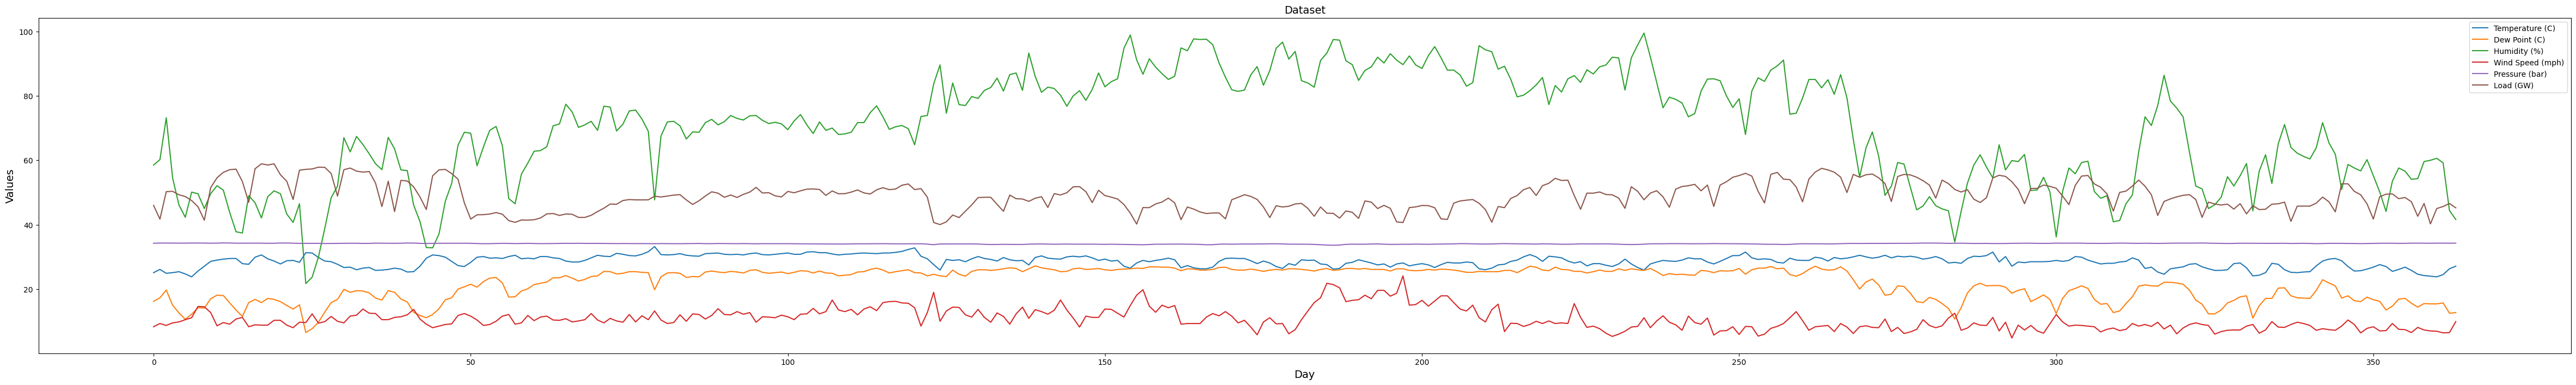


Independent & Dependent variables arrays:
x_temperature: (364, 1)
x_dewpoint: (364, 1)
x_humidity: (364, 1)
x_windspeed: (364, 1)
x_pressure: (364, 1)
y: (364, 1)

Stacked Dataset (364, 6) :
 [[0.13829787 0.46859903 0.47300771 0.18134715 0.86511628 0.31501404]
 [0.24468085 0.52173913 0.49485861 0.23316062 0.95348837 0.08956489]
 [0.11702128 0.63768116 0.66195373 0.20207254 0.94418605 0.54194711]
 ...
 [0.07446809 0.44444444 0.48200514 0.08290155 0.91627907 0.29757804]
 [0.26595745 0.28985507 0.29177378 0.0880829  0.88372093 0.34665324]
 [0.35106383 0.29951691 0.25578406 0.2642487  0.91162791 0.27569029]]

X.shape  (321, 30, 5)
y.shape (321, 15)

train_X (318, 30, 5)
train_y (318, 15)
test_X (3, 30, 5)
test_y (3, 15)
Epoch 1/100
11/11 [==============================] - 3s 58ms/step - loss: 0.3047 - mse: 0.3047 - val_loss: 0.1659 - val_mse: 0.1659
Epoch 2/100
11/11 [==============================] - 0s 19ms/step - loss: 0.2816 - mse: 0.2816 - val_loss: 0.1551 - val_mse: 0.1551
Epoch 3/1

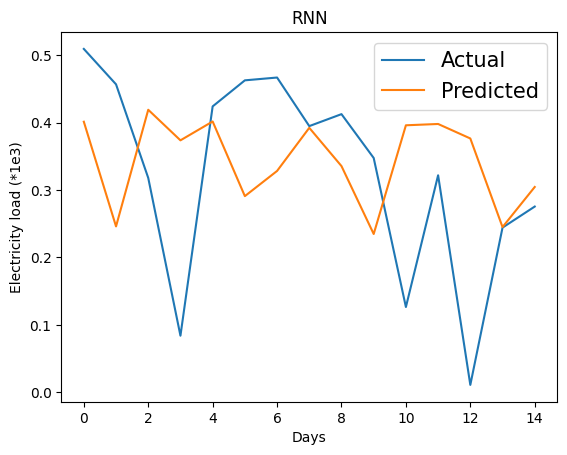

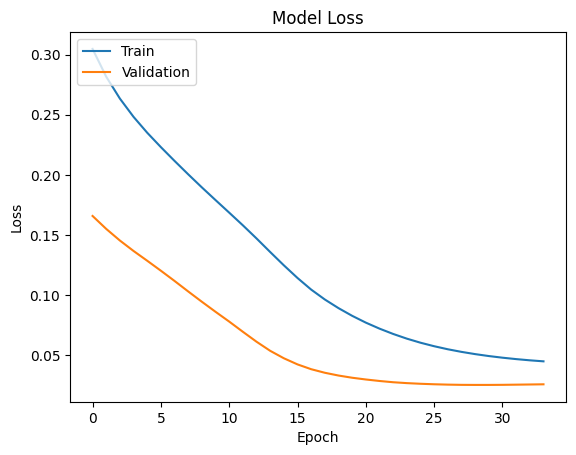

RMSE: 169.55093777655134
R-squared: -0.35350818256612415
MAPE: 2.792656723269769 

Total time:  16.832935094833374


In [ ]:
from __future__ import print_function
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Activation
from tensorflow import keras
from sklearn.metrics import mean_squared_error, r2_score
import os
from tensorflow.python.keras.callbacks import EarlyStopping
import warnings
from keras.models import load_model, save_model

warnings.filterwarnings("ignore", category=DeprecationWarning)

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

start_time = time.time()

# Reading from the database
dataset = pd.read_csv('hourly_load&weather_data.csv')
x_temperature = dataset['Temperature']
x_dewpoint = dataset['Dew Point']
x_humidity = dataset['Humidity']
x_windspeed = dataset['Wind Speed']
x_pressure = dataset['Pressure']
y = dataset['Load']

# Converting the values in the usable format
x_temperature = x_temperature.values
x_dewpoint = x_dewpoint.values
x_humidity = x_humidity.values
x_windspeed = x_windspeed.values
x_pressure = (x_pressure.values) / 29.53  # Hg to bar
y = (y.values) / 1000  # MW to GW


# Visualising the independent variables
dataset_graph = plt.figure(figsize=(60, 8))
plt.plot(x_temperature[:364], label='Temperature (C)')
plt.plot(x_dewpoint[:364], label='Dew Point (C)')
plt.plot(x_humidity[:364], label='Humidity (%)')
plt.plot(x_windspeed[:364], label='Wind Speed (mph)')
plt.plot(x_pressure[:364], label='Pressure (bar)')
plt.plot(y[:364], label='Load (GW)')
plt.legend(loc='upper right')
plt.title("Dataset", fontsize=14)
plt.xlabel('Day', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.legend()
plt.show()


# Converting to a usable format in a 2D array
x_temperature = x_temperature.reshape((len(x_temperature), 1))
x_dewpoint = x_dewpoint.reshape((len(x_dewpoint), 1))
x_humidity = x_humidity.reshape((len(x_humidity), 1))
x_windspeed = x_windspeed.reshape((len(x_windspeed), 1))
x_pressure = x_pressure.reshape((len(x_pressure), 1))
y = y.reshape((len(y), 1))

print("\nIndependent & Dependent variables arrays:")
print("x_temperature:", x_temperature.shape)
print("x_dewpoint:", x_dewpoint.shape)
print("x_humidity:", x_humidity.shape)
print("x_windspeed:", x_windspeed.shape)
print("x_pressure:", x_pressure.shape)
print("y:", y.shape)

# Normalising the data using the MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
x_temperature_scaled = scaler.fit_transform(x_temperature)
x_dewpoint_scaled = scaler.fit_transform(x_dewpoint)
x_humidity_scaled = scaler.fit_transform(x_humidity)
x_windspeed_scaled = scaler.fit_transform(x_windspeed)
x_pressure_scaled = scaler.fit_transform(x_pressure)
y_scaled = scaler.fit_transform(y)


# Stacking the data columns horizontally
stacked_dataset = np.hstack(
    (x_temperature_scaled, x_dewpoint_scaled, x_humidity_scaled, x_windspeed_scaled, x_pressure_scaled, y_scaled))
print("\nStacked Dataset", stacked_dataset.shape, ":\n", stacked_dataset)


#Split a multivariate sequence into samples
def split_sequences(dataset, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(dataset)):
        start = i + n_steps_in
        end = start + n_steps_out-1
        if end > len(dataset):
            break
        x_sequence, y_sequence = dataset[i:start, :-1], dataset[start-1:end, -1]
        X.append(x_sequence)
        y.append(y_sequence)
    return np.array(X), np.array(y)

n_steps_in, n_steps_out, n_features = 30 , 15, 5
X, y = split_sequences(stacked_dataset, n_steps_in, n_steps_out)
print ("\nX.shape " , X.shape)
print ("y.shape" , y.shape)

#Splitting into training & test sets
train_X, train_y = X[:318, :], y[:318, :]
test_X, test_y = X[318:, :], y[318:, :]
print ("\ntrain_X" , train_X.shape)
print ("train_y" , train_y.shape)
print ("test_X" , test_X.shape)
print ("test_y" , test_y.shape)


#Learning Rate
opt = keras.optimizers.Adam(learning_rate=0.0001)

#GRU Model
model = Sequential()
model.add(SimpleRNN(50, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(SimpleRNN(50, activation='relu'))
model.add(Dense(n_steps_out))
model.add(Activation('linear'))
model.compile(loss='mse' , optimizer=opt , metrics=['mse'])
es = EarlyStopping(monitor="val_loss", min_delta=0, patience=5, verbose=1, mode="auto", baseline=None,
                   restore_best_weights=True)  # Stops the training when the values don't improve
history = model.fit(train_X, train_y, epochs=100, batch_size=30, verbose=1, validation_data=(test_X, test_y), callbacks=[es], shuffle=False)
print(model.summary())

# Evaluating the result
test_mse = model.evaluate(test_X, test_y, verbose=1)
# print('\nThe Mean-squared-error (MSE) on the test data set is %.6f over %d test samples.' % (test_mse, len(test_y)))
print("Test MSE:", test_mse)

# loaded_model = load_model('path')

# print("X", test_X.shape, test_X[65])
# Getting the predicted values
predicted_values = model.predict(test_X[0].reshape((1,30,5)))
scaler1 = MinMaxScaler(feature_range=(0, 1))
scaler1.fit(y)
y_pred = scaler1.inverse_transform(predicted_values)
test_scaled = scaler1.inverse_transform([test_y[0]])
y_pred = y_pred.reshape((15,))
test_scaled = test_scaled.reshape((15,))
print("P", y_pred)
print("y", test_scaled)
print("p", predicted_values, predicted_values.reshape((15,)))
print("y", test_y[0], test_y[0].shape)

# Plotting the results
fig = plt.figure()
# plt.plot((test_y[0]))
# plt.plot(predicted_values.reshape((15,)))
plt.plot(test_scaled)
plt.plot(y_pred.reshape((15,)))
plt.title('RNN')
plt.xlabel('Days')
plt.ylabel('Electricity load (*1e3)')
plt.legend(('Actual', 'Predicted'), fontsize='15')
plt.show()


# Plot of the loss
loss_fig = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


end_time = time.time()

# print("MSE:", mean_squared_error(test_y[65].reshape((1,15))*1000, predicted_values*1000))
# print("RMSE:", mean_squared_error(test_y[65].reshape((1,15))*1000, predicted_values*1000, squared=False))
# print("MSE:", mean_squared_error(test_y[0]*1000, predicted_values.reshape((15,))*1000))
# print("RMSE:", mean_squared_error(test_y[0]*1000, predicted_values.reshape((15,))*1000, squared=False))
print("RMSE:", mean_squared_error(test_scaled*1000, y_pred*1000, squared=False))
# print("R-squared:", r2_score(test_y[65].reshape((1,15))*1000, predicted_values*1000))
print("R-squared:", r2_score(test_scaled, y_pred))
print('MAPE:', np.mean(np.abs((test_scaled*1000 - y_pred*1000) / (test_scaled*1000))),'\n')
print("Total time: ", end_time - start_time)

                               SARIMAX Results                                
Dep. Variable:                      1   No. Observations:                  354
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 764.271
Date:                Thu, 18 Jan 2024   AIC                          -1522.543
Time:                        08:28:20   BIC                          -1510.960
Sample:                             0   HQIC                         -1517.933
                                - 354                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5199      0.055      9.449      0.000       0.412       0.628
ma.L1         -0.8627      0.044    -19.390      0.000      -0.950      -0.775
sigma2         0.0008   4.56e-05     16.451      0.0

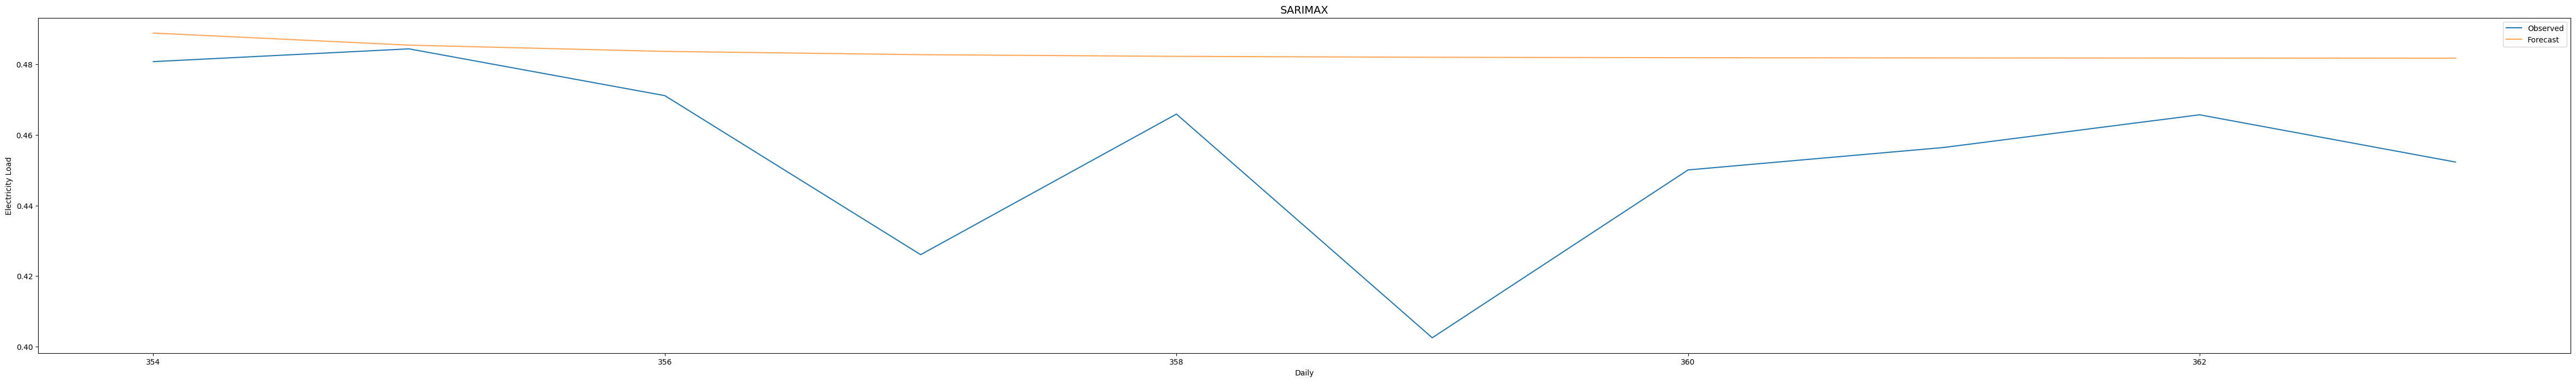

In [ ]:
import warnings
import pandas as pd
import numpy as np
import math
import itertools as iter
import statsmodels.api as stats
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, r2_score

warnings.filterwarnings("ignore")

# Pre-processing of the data
df_raw = pd.read_csv('hourly_load&weather_data.csv', header=None, skiprows=1)  # loading raw data from the CSV
df_raw_array = df_raw.values  # numpy array
y_train = df_raw[1]/100000
y_train = y_train[0:354]
y_test = df_raw[1]/100000


# SARIMAX model
model = stats.tsa.statespace.SARIMAX(y_test[:354], order=[1, 1, 1],
                                   seasonal_order=[0,0,0,120], enforce_stationarity=False,
                                   enforce_invertibility=False)


results = model.fit()
print(results.summary())

# results.plot_diagnostics()
# plt.show()

# y_pred = results.get_prediction(start=328, dynamic=True)
# pred_ci = y_pred.conf_int()

y_pred = results.get_forecast(steps=10)

# Get confidence intervals of forecasts
pred_ci = y_pred.conf_int()

# print(y_test[354:], y_pred.predicted_mean)
# mse = mean_squared_error(y_test[327:]*100, y_pred*100)
y_forecasted = y_pred.predicted_mean
y_truth = y_test[354:]


# Compute the mean square error
mse = ((y_forecasted*100000 - y_truth*100000) ** 2).mean()

print(y_forecasted, y_truth)

print("RMSE: ", math.sqrt(mse))
print('MAPE:', np.mean(np.abs(y_truth - y_forecasted) / (y_truth)) * 100,'\n')
# print('RMSE:', mean_squared_error(y_test[327:] * 100, y_pred.predicted_mean*100, squared=False))
# print('R-squared:', r2_score(y_test[327:], y_pred.predicted_mean))

# Plotting the results
fig = plt.figure(figsize=(60, 8))
ax = y_test[354:].plot(label='Observed')
y_pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7)

ax.set_xlabel('Daily')
ax.set_ylabel('Electricity Load')

# plt.plot(y_test[31925:]*100, label='Actual')
# plt.plot(y_pred*100, label='Predicted')
plt.legend(loc='upper right')
plt.title("SARIMAX", fontsize=14)
# plt.xlabel('Daily')
# plt.ylabel('Electricity load')
plt.show()


# Storing the result in a file: 'load_forecasting_result.txt'
predicted_test_result = y_pred.predicted_mean * 100000

actual_test_result = y_test[354:] * 100000


---------------------------------------------------------


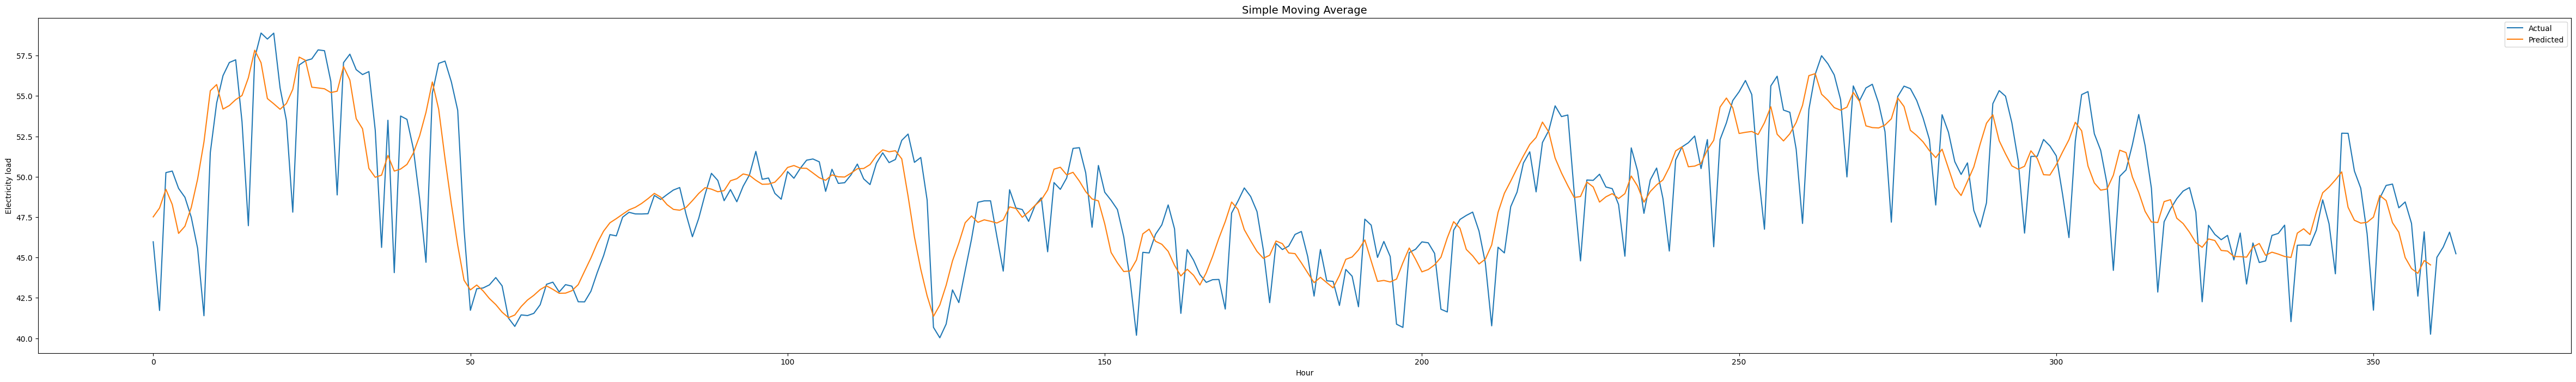

MSE for SMA:  6.79369875922222
RMSE for SMA: 2606.4724742882327
R-squared for SMA: 0.5020577310943233
MAPE for SMA: 4.010782455801165
---------------------------------------------------------


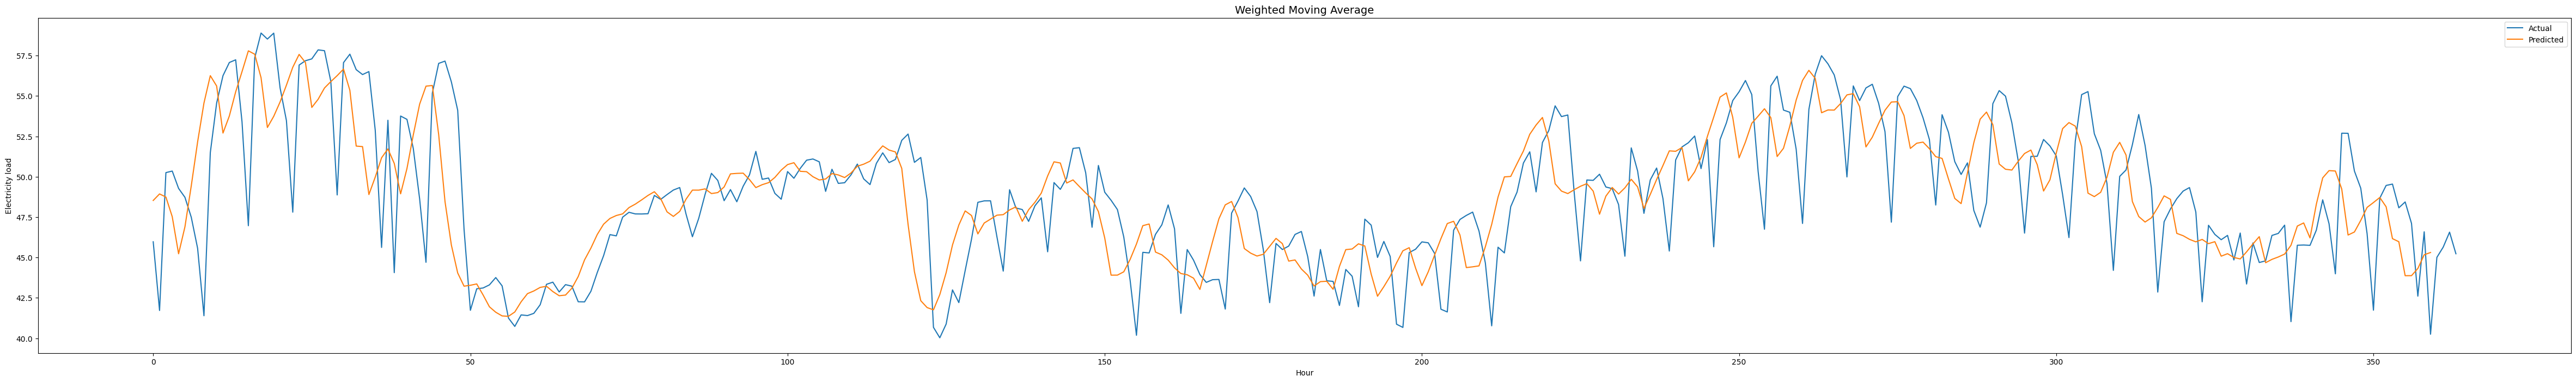

MSE for WMA:  4.110031209370371
RMSE for WMA: 2027.3211904802777
R-squared for WMA: 0.7111574168909791
MAPE for WMA: 3.128610703176565
---------------------------------------------------------


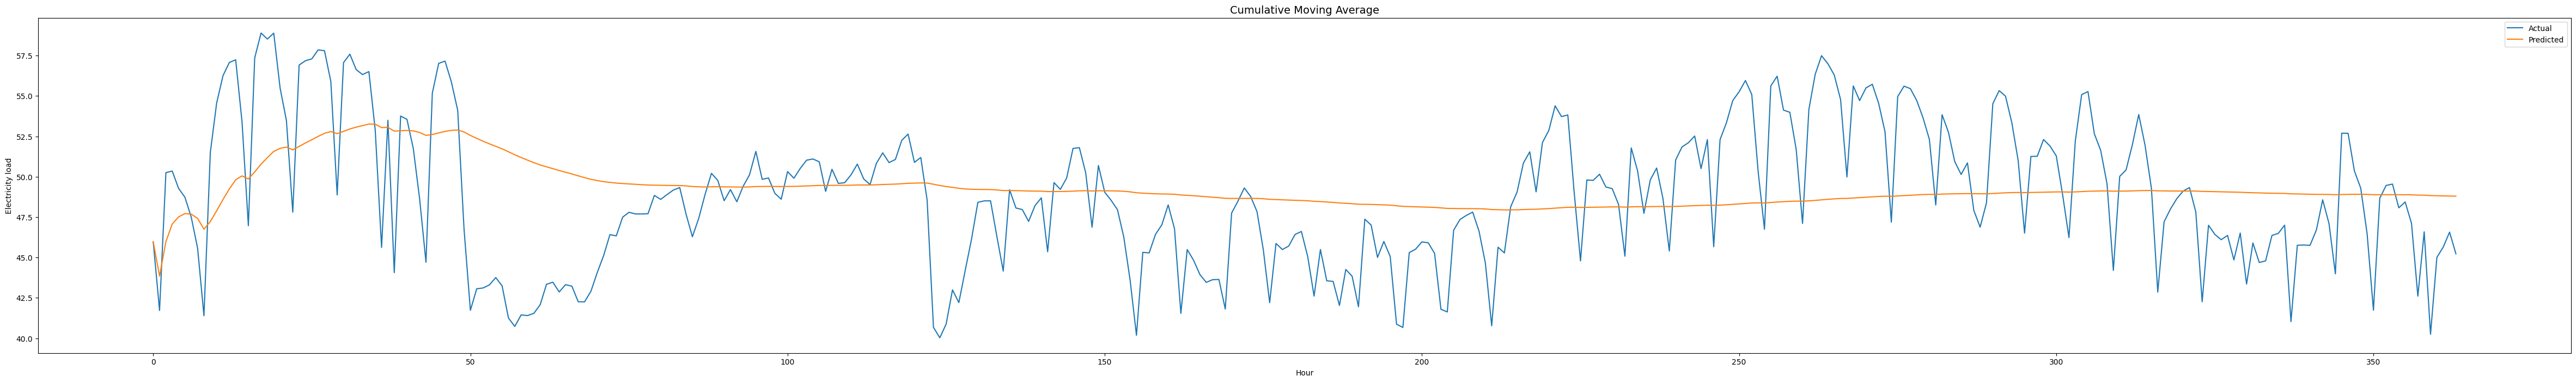

MSE for CMA:  18.62111860722196
RMSE for CMA: 4315.219415883966
R-squared for CMA: -9.53783481092755
MAPE for CMA: 0    7.224245
dtype: float64
---------------------------------------------------------


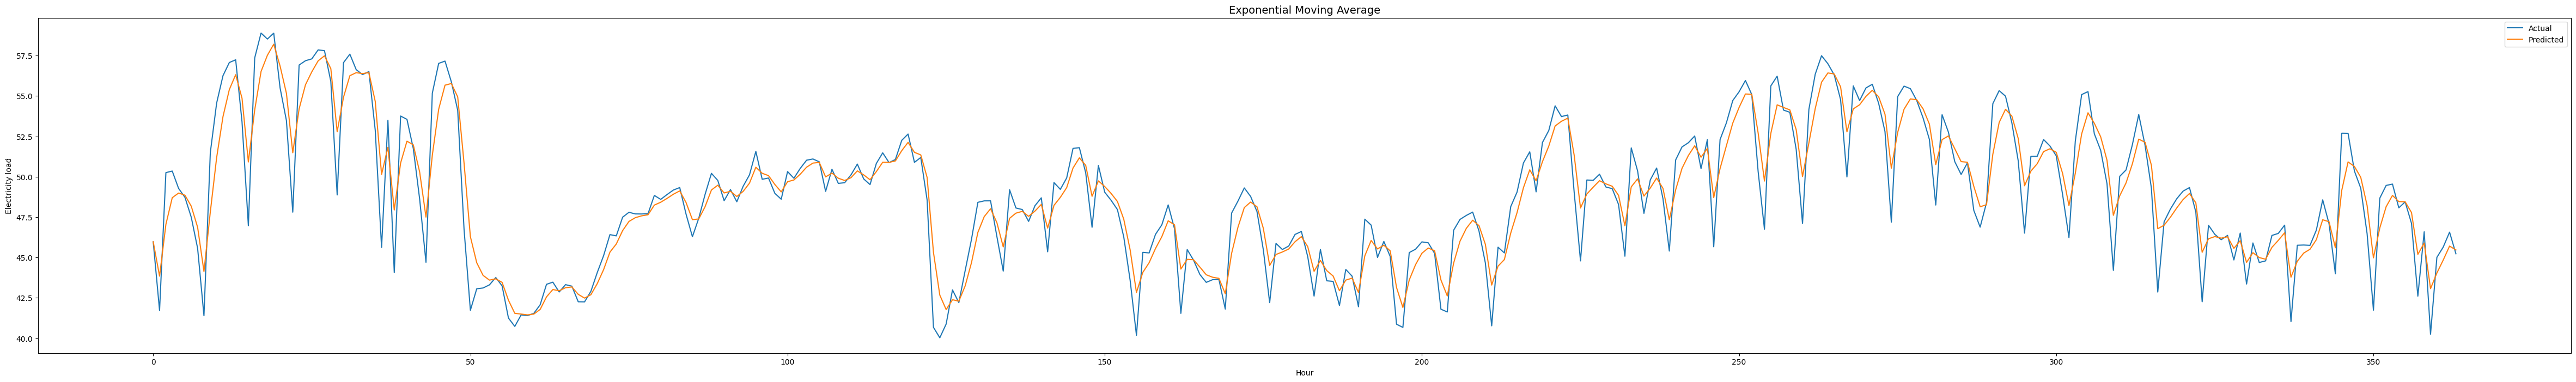

MSE for EMA:  2.1136976290104155
RMSE for EMA: 1453.8561239030553
R-squared for EMA: 0.8563860017458871
MAPE for EMA: 0    2.230758
dtype: float64
---------------------------------------------------------


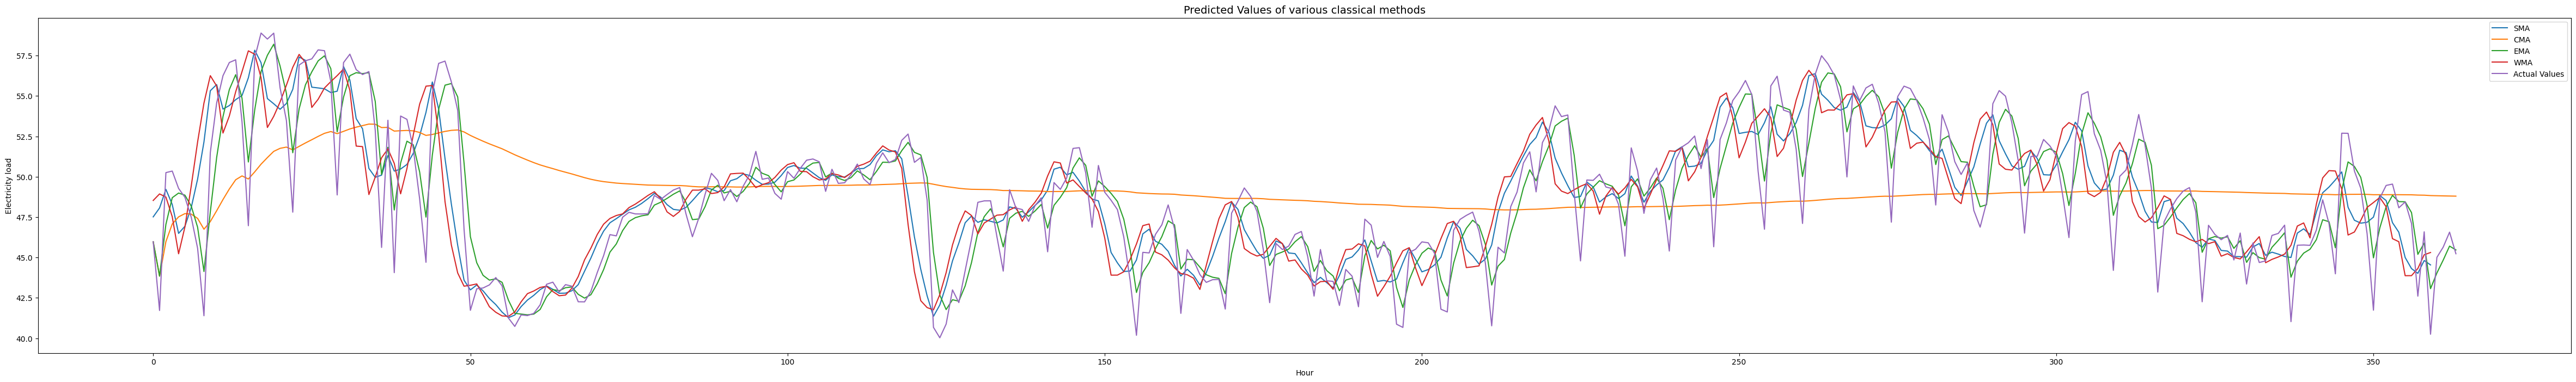

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Pre-processing of the data
df_raw = pd.read_csv('hourly_load&weather_data.csv', header=None, skiprows=1)  # loading raw data from the CSV
y_test = df_raw[1].values/1000  # numpy array
# print("y_test: ", y_test.shape, "\n", y_test, "\n")


def simple_moving_average(n, y_test):
    # Getting the predicted values for SMA
    y_pred = pd.Series(y_test).rolling(window=n).mean().iloc[n - 1:].values
    # print("Predicted values: ", y_pred, "\n")
    mse_sma = mean_squared_error(y_test[n - 1:], y_pred)

    # Plotting the results
    fig = plt.figure(figsize=(60, 8))
    plt.plot(y_test, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.legend(loc='upper right')
    plt.title("Simple Moving Average", fontsize=14)
    plt.xlabel('Hour')
    plt.ylabel('Electricity load')
    plt.show()

    # Storing the result in a file: 'load_forecasting_result.txt'
    predicted_test_result = y_pred
    actual_test_result = y_test

    return mse_sma, y_pred


def weighted_moving_average(n, y_test):
    y_pred = []
    for i in range(len(y_test) - 4):
        total = np.arange(1, n + 1, 1)  # Weight Matrix for current being the heaviest
        temp = y_test[i:i + n]
        temp = total * temp
        wma = (temp.sum()) / (total.sum())
        y_pred = np.append(y_pred, wma)

    # print("Predicted values: ", y_pred, "\n")
    mse_wma = mean_squared_error(y_test[n - 1:], y_pred)

    # Plotting the results
    fig = plt.figure(figsize=(60, 8))
    plt.plot(y_test, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.legend(loc='upper right')
    plt.title("Weighted Moving Average", fontsize=14)
    plt.xlabel('Hour')
    plt.ylabel('Electricity load')
    plt.show()

    # Storing the result in a file: 'load_forecasting_result.txt'
    predicted_test_result = y_pred
    actual_test_result = y_test

    return mse_wma, y_pred


def cumulative_moving_average(y_test):
    df = pd.DataFrame(y_test)
    y_pred = df.expanding().mean()

    # print("Predicted values: ", y_pred, "\n")
    mse_cma = mean_squared_error(y_test, y_pred)

    # Plotting the results
    fig = plt.figure(figsize=(60, 8))
    plt.plot(y_test, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.legend(loc='upper right')
    plt.title("Cumulative Moving Average", fontsize=14)
    plt.xlabel('Hour')
    plt.ylabel('Electricity load')
    plt.show()

    # Storing the result in a file: 'load_forecasting_result.txt'
    predicted_test_result = y_pred
    actual_test_result = y_test

    return mse_cma, y_pred


def exponential_moving_average(y_test):
    df = pd.DataFrame(y_test)
    smoothing_factor = 0.5
    y_pred = df.ewm(alpha=smoothing_factor, adjust=False).mean()

    # print("Predicted values: ", y_pred, "\n")
    mse_ema = mean_squared_error(y_test, y_pred)

    # Plotting the results
    fig = plt.figure(figsize=(60, 8))
    plt.plot(y_test, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.legend(loc='upper right')
    plt.title("Exponential Moving Average", fontsize=14)
    plt.xlabel('Hour')
    plt.ylabel('Electricity load')
    plt.show()


    # Storing the result in a file: 'load_forecasting_result.txt'
    predicted_test_result = y_pred

    actual_test_result = y_test


    return mse_ema, y_pred


print("---------------------------------------------------------")

n = 5  # Window size
mse_sma, y_sma = simple_moving_average(n, y_test)
print("MSE for SMA: ", mse_sma)
print('RMSE for SMA:', mean_squared_error(y_sma * 1000, y_test[n - 1:] * 1000, squared=False))
print('R-squared for SMA:', r2_score(y_sma, y_test[n - 1:]))
print('MAPE for SMA:', np.mean(np.abs((y_test[n-1:] - y_sma) / y_test[n-1:])) * 100)

print("---------------------------------------------------------")

mse_wma, y_wma = weighted_moving_average(n, y_test)
print("MSE for WMA: ", mse_wma)
print('RMSE for WMA:', mean_squared_error(y_wma * 1000, y_test[n - 1:] * 1000, squared=False))
print('R-squared for WMA:', r2_score(y_wma, y_test[n - 1:]))
print('MAPE for WMA:', np.mean(np.abs((y_test[n-1:] - y_wma) / y_test[n-1:])) * 100)

print("---------------------------------------------------------")
y = np.reshape(y_test, (364,1))
mse_cma, y_cma = cumulative_moving_average(y_test)
print("MSE for CMA: ", mse_cma)
print('RMSE for CMA:', mean_squared_error(y_cma * 1000, y * 1000, squared=False))
print('R-squared for CMA:', r2_score(y_cma, y_test))
print('MAPE for CMA:', np.mean(np.abs((y - y_cma) / y)) * 100)

print("---------------------------------------------------------")

mse_ema, y_ema = exponential_moving_average(y_test)
print("MSE for EMA: ", mse_ema)
print('RMSE for EMA:', mean_squared_error(y_ema * 1000, y_test * 1000, squared=False))
print('R-squared for EMA:', r2_score(y_ema, y_test))
print('MAPE for EMA:', np.mean(np.abs((y - y_ema) / y)) * 100)

print("---------------------------------------------------------")


# Plotting the results
fig = plt.figure(figsize=(60, 8))
plt.plot(y_sma, label='SMA')
plt.plot(y_cma, label='CMA')
plt.plot(y_ema, label='EMA')
plt.plot(y_wma, label='WMA')
plt.plot(y_test, label='Actual Values')
plt.legend(loc='upper right')
plt.xlabel('Hour')
plt.ylabel('Electricity load')
plt.title("Predicted Values of various classical methods", fontsize=14)
plt.show()

---------------------------------------------------------


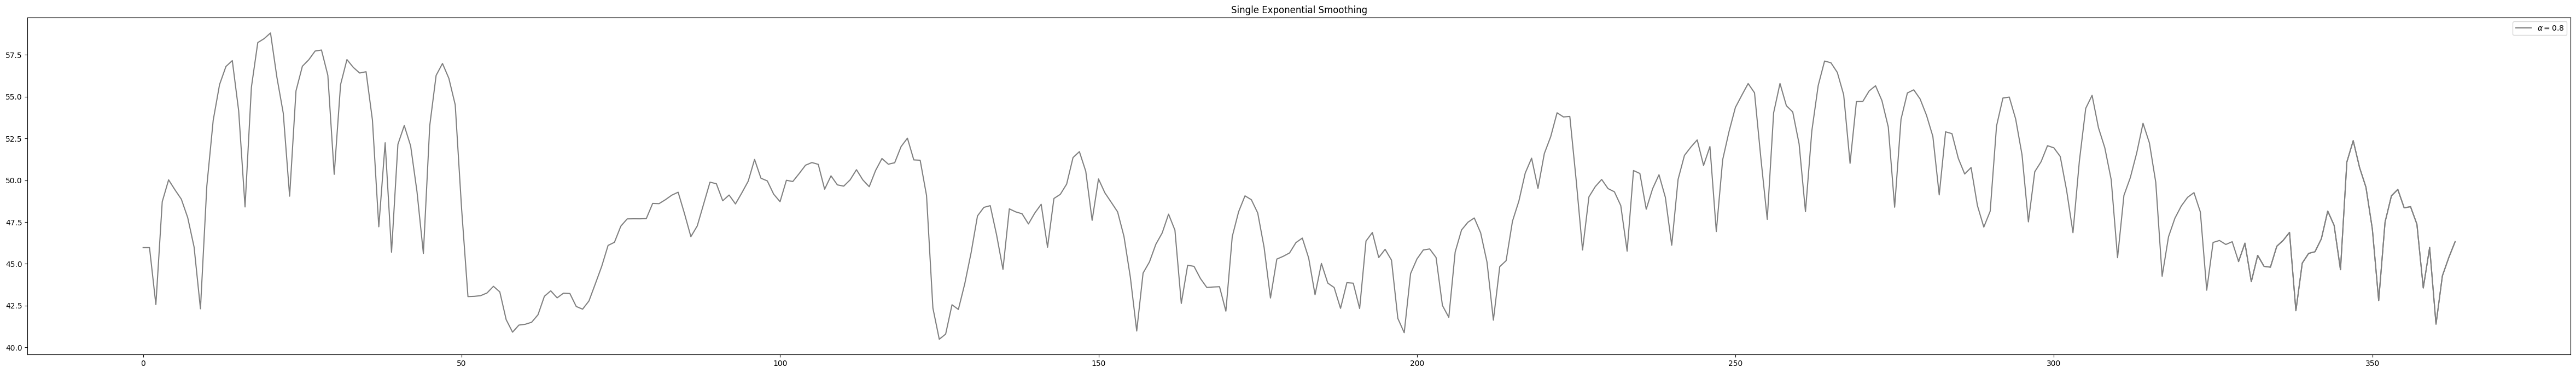

MSE for SES:  355371.2051973372
RMSE for SES: 596.1301914828146
R-squared for SES: 0.9527115129967839
MAPE for SES: 0.990804227137556 

---------------------------------------------------------


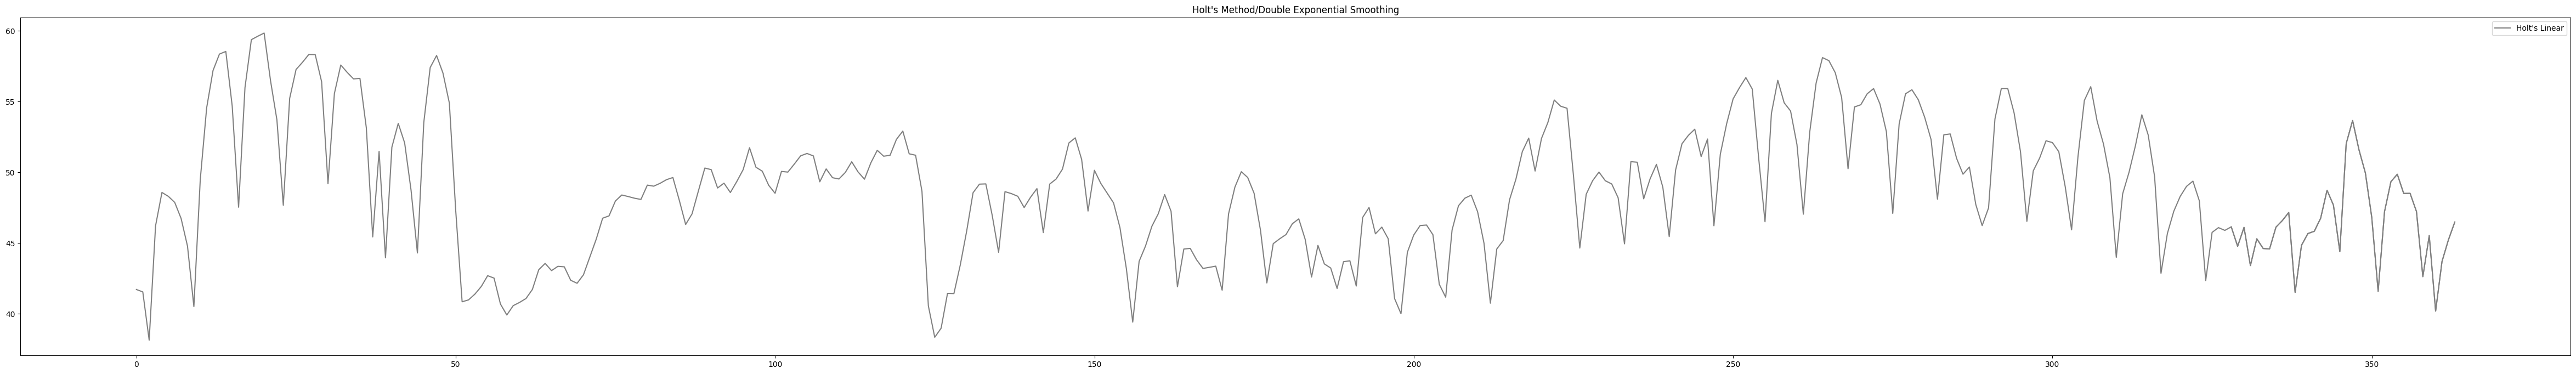

MSE for DES:  313230.493080752
RMSE for DES: 559.6699858673431
R-squared for DES: 0.9583190875219197
MAPE for DES: 0.8474736215529157 

---------------------------------------------------------


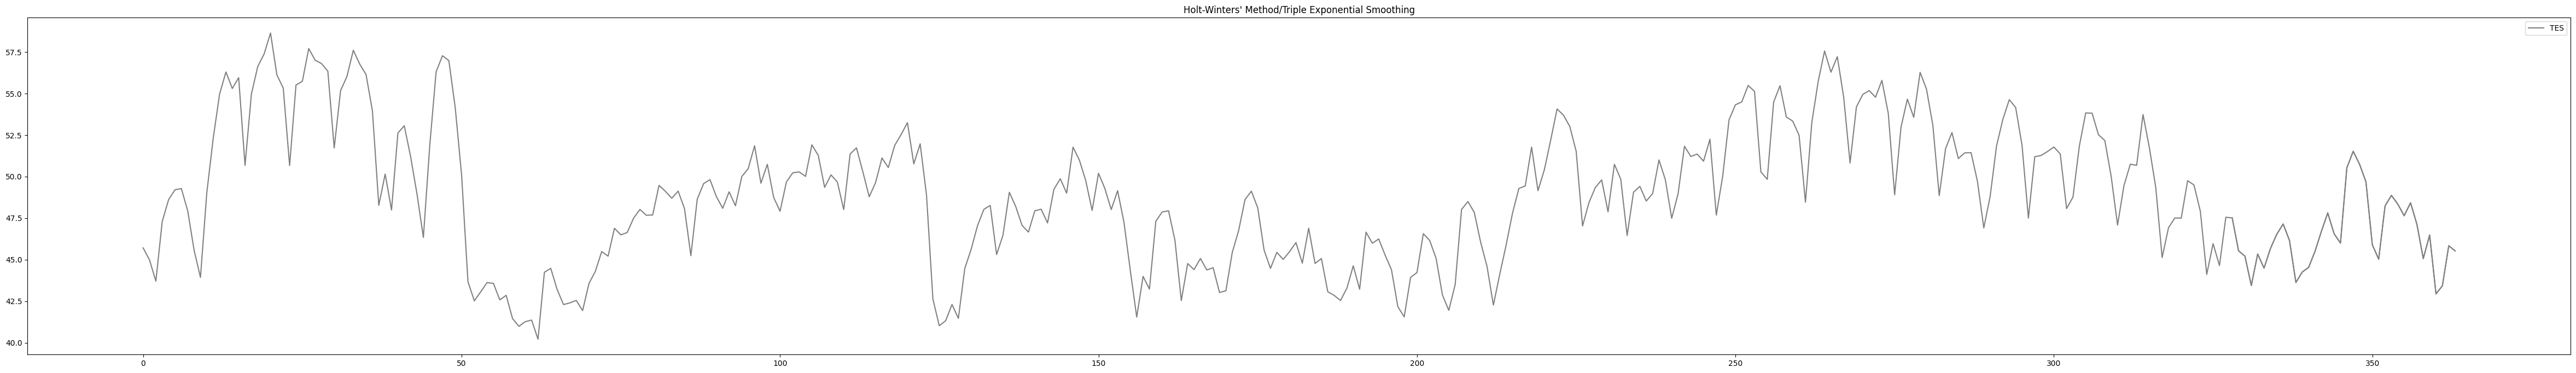

MSE for TES:  1610043.853986158
RMSE for TES: 1268.8750348187004
R-squared for TES: 0.7857549043075849
MAPE for TES: 2.103210023770004 

---------------------------------------------------------


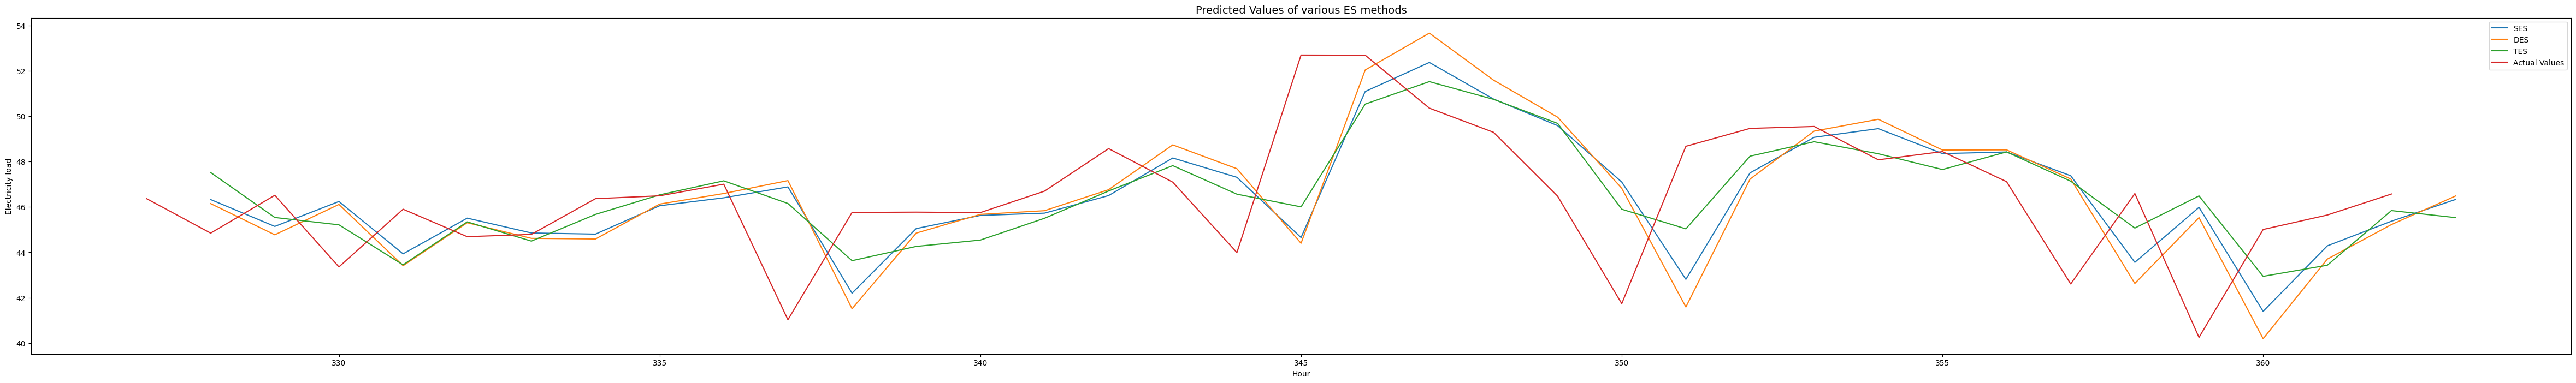

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
import warnings

warnings.filterwarnings("ignore")

# Pre-processing of the data
df_raw = pd.read_csv('hourly_load&weather_data.csv', header=None, skiprows=1)  # loading raw data from the CSV
df_raw_array = df_raw.values  # numpy array
y_test = df_raw[1]/1000
x_test = np.delete(df_raw_array, 0, 1)
x_test = np.delete(x_test, 6, 1)
# print(x_test)
y_test = np.array(y_test)
# print("y_test: ", y_test.shape, "\n", y_test, "\n")


def single_exponential_smoothing(alpha, y_test):
    # Accounts only for the level of the series

    # Simple Exponential Smoothing
    ses_model1 = SimpleExpSmoothing(endog=y_test).fit(smoothing_level=alpha, optimized=True)
    y_pred_ses = ses_model1.predict(328).rename(r'$\alpha=%s$' % ses_model1.model.params['smoothing_level'])

    fig = plt.figure(figsize=(60, 8))
    y_pred_ses[1:].plot(color='grey', legend=True)
    ses_model1.fittedvalues.plot(color='grey')
    plt.title("Single Exponential Smoothing")
    plt.show()

    # print("Predicted values: ", y_pred, "\n")
    mse_ses = mean_squared_error(y_test[327:-1]*1000, y_pred_ses*1000)
    rmse_ses = mean_squared_error(y_pred_ses*1000, y_test[327:-1]*1000, squared=False)
    r2_ses = r2_score(y_test[327:-1]*1000, y_pred_ses*1000)

    # Storing the result in a file: 'load_forecasting_result.txt'
    predicted_test_result = y_pred_ses
    actual_test_result = y_test

    return mse_ses, rmse_ses, r2_ses, y_pred_ses


def double_exponential_smoothing(alpha, beta, y_test):
    # Accounts for level + trend in the data

    des_model = Holt(y_test).fit(smoothing_level=alpha, smoothing_trend=beta, optimized=False)
    y_pred_des = des_model.predict(328).rename("Holt's Linear")

    fig = plt.figure(figsize=(60, 8))
    des_model.fittedvalues.plot(color='grey')
    y_pred_des.plot(color='grey', legend=True)
    plt.title("Holt's Method/Double Exponential Smoothing")
    plt.show()

    # print("Predicted values: ", y_pred_des, "\n")
    mse_des = mean_squared_error(y_test[327:-1]*1000, y_pred_des*1000)
    rmse_des = mean_squared_error(y_pred_des*1000, y_test[327:-1]*1000, squared=False)
    r2_des = r2_score(y_test[327:-1]*1000, y_pred_des*1000)

    actual_test_result = y_test



    return mse_des, rmse_des, r2_des, y_pred_des


def triple_exponential_smoothing(season, y_test):
    # Accounts for level + trend + seasonality in the data
    # Three models with different parameters

    # Model 1: Additive trend + season with box-cox transformation
    tes_model = ExponentialSmoothing(y_test, seasonal_periods=season, trend='add', seasonal='add').fit()
    y_pred_tes = tes_model.predict(328).rename("TES")

    fig = plt.figure(figsize=(60, 8))
    tes_model.fittedvalues.plot(color='grey')
    y_pred_tes.plot(color='grey', legend=True)

    plt.title("Holt-Winters' Method/Triple Exponential Smoothing")
    plt.show()

    # print("Predicted values: ", y_pred_tes, "\n")
    mse_tes = mean_squared_error(y_test[327:-1]*1000, y_pred_tes*1000)
    rmse_tes = mean_squared_error(y_pred_tes*1000, y_test[327:-1]*1000, squared=False)
    r2_tes = r2_score(y_test[327:-1]*1000, y_pred_tes*1000)

    actual_test_result = y_test



    return mse_tes, rmse_tes, r2_tes, y_pred_tes


alpha = 0.8
beta = 0.2
season = 24
y_test = pd.DataFrame(y_test)
y = np.reshape(np.array(y_test[327:-1]), (36,))
print("---------------------------------------------------------")

mse_ses, rmse_ses, r2_ses, y_ses = single_exponential_smoothing(alpha, y_test)
print("MSE for SES: ", mse_ses)
print('RMSE for SES:', rmse_ses)
print('R-squared for SES:', r2_ses)
print('MAPE for SES:', np.mean(np.abs((y - np.array(y_ses)) / y)) * 100,'\n')

print("---------------------------------------------------------")

mse_des, rmse_des, r2_des, y_des = double_exponential_smoothing(alpha, beta, y_test)
print("MSE for DES: ", mse_des)
print('RMSE for DES:', rmse_des)
print('R-squared for DES:', r2_des)
print('MAPE for DES:', np.mean(np.abs((y - np.array(y_des)) / y)) * 100,'\n')

print("---------------------------------------------------------")

mse_tes, rmse_tes, r2_tes, y_tes = triple_exponential_smoothing(season, y_test)
print("MSE for TES: ", mse_tes)
print('RMSE for TES:', rmse_tes)
print('R-squared for TES:', r2_tes)
print('MAPE for TES:', np.mean(np.abs((y - np.array(y_tes)) / y)) * 100,'\n')

print("---------------------------------------------------------")


# Plotting the results
fig = plt.figure(figsize=(60, 8))
plt.plot(y_ses, label='SES')
plt.plot(y_des, label='DES')
plt.plot(y_tes, label='TES')
plt.plot(y_test[327:-1], label='Actual Values')
plt.legend(loc='upper right')
plt.xlabel('Hour')
plt.ylabel('Electricity load')
plt.title("Predicted Values of various ES methods", fontsize=14)
plt.show()
